## TheClairvoyantConstructor

Andy Upton

_21 March 2019_

## Goals
You are a data scientist at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like you to work on forecasting core construction material costs. You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format.

Currently, the company is able to purchase futures contracts in a material for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase.

## Key Findings

### Steel

Steel prices tend to hike in the winter season, generally starting a significant rise at the end of October but then tends to subside in price at the end of March. It's price has increased overtime noticeably, but has been on a downward trend compared to the highs of 2016. If possible, I recommend purchasing steel in the late summer for all projects that take place between October - March. Steel tends to be cheaper on the weekends - Saturday and Sunday.

The forecast suggests that steel should be purchased in bulk as soon as possible at around the $8-9 per unit amount.

### Rebar

Rebar is trending significantly upward in price and, like steel, tends to spike in the winter months. However, rebar shows a unique trend compared to steel in that it typically reaches its lowest price for the year in the early summer but with substantial fluctuations that are difficult to predict around. Rebar should be purchased in bulk, as allows, during the early summer months of May and June. If it can't be avioded, purchasing for winter projects/demand should take place in October.  

The forecast for rebar suggests that bulk purchases should be made as soon as possible as once the price increases above $20 per unit, it's likely to rise much higher at a rapid pace. Rebar tends to be lowest in price on Sundays and highest on Saturdays.


### Glass

The data for glass is the most sparse, and as such the trends should be noted as being more difficult to predict. Glass is trending as being pricey, which should be reflected in cost models for the material in bids, etc. No significant downward or upward trend is able to be predicted for the next 6 months for glass, but it does tend to increase in price during the Spring months of March, April, and May. Prices at ~$35 per unit are possible soon but if the prices begin to rise, it is suggested to buy in bulk at the first sign. 

Glass should not be purchased on Saturdays if possible, as they tend to have much higher prices on Saturdays. 

### Concrete

Concrete tends to increase in price in the late Spring and into the early Summer before declining significantly in the late summer. As a result, it should be purchased in July and August in bulk if possible and on Sundays if possible. The forecast suggests that a major dip in prices is in store and waiting a month or two would be recommended to see a drop in price from today's date. The price may drop as low as ~$35 per unit in the coming weeks or months before rising to above \\$30-40 per unit later this year. Concrete drops in price on Sundays, so be on the lookout for deals on Sundays. 

### Plywood

Plywood sees major fluctuations in price during a given year, but in particular spikes dramatically in price in the late winter, late summer, and most noticably in October. These spikes have likely cut into company profits. The pricing forecasts suggests an increase is likely in the next month or two, which will followed by a substantial drop in price before it rises again. Buy as soon as the price goes under $11-12, which should be in the next few months.

Buy plywood later in the week if possible. 

In [1]:
# Bring in libraries
import pandas as pd
import numpy as np

# Bring in some plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')

from fbprophet import Prophet
from datetime import datetime

In [2]:
! ls ..

README.md
Submissions
construction_material_prices_2008_2018.csv


In [19]:
df = pd.read_csv('../construction_material_prices_2008_2018.csv', index_col=0)

# Convert the index of the DataFrame to datetime
df.index = pd.to_datetime(df.index)


In [20]:
df.head()

price_steel  price_rebar  price_glass  price_concrete  \
2007-01-01          NaN          NaN          NaN             NaN   
2007-01-03          NaN          NaN          NaN             NaN   
2007-01-04          NaN          NaN          NaN             NaN   
2007-01-05          NaN          NaN          NaN             NaN   
2007-01-08          NaN          NaN          NaN             NaN   

            price_plywood  
2007-01-01            NaN  
2007-01-03            NaN  
2007-01-04            NaN  
2007-01-05            NaN  
2007-01-08            NaN

In [21]:
# Ok, got some missing data. How much?
df.isna().sum()

price_steel        636
price_rebar       1296
price_glass       1473
price_concrete    1498
price_plywood      272
dtype: int64

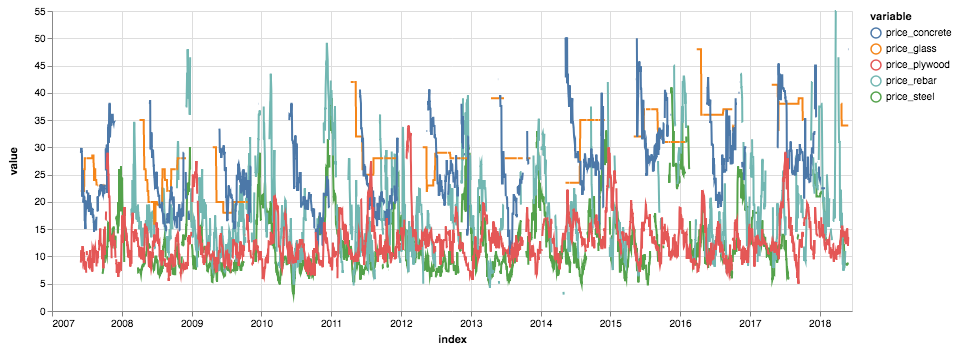

In [166]:
# Altair throws an error if the dataset is more than 5000 rows, have to disable this
alt.data_transformers.enable('default', max_rows=None)

source = pd.melt(df.reset_index(), id_vars='index')

alt.Chart(source).mark_line().encode(
    x='index',
    y='value',
    color='variable'
).properties(width=800)

In [51]:
# Let's interpolate
df_interp_lin = df.interpolate('linear')

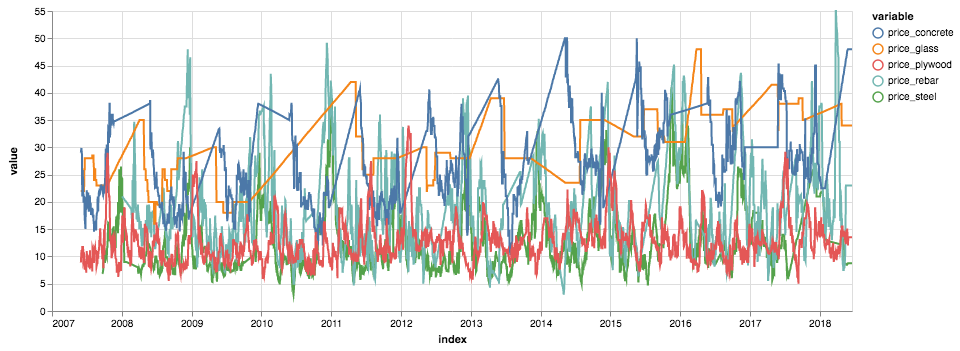

In [167]:
source = pd.melt(df_interp_lin.reset_index(), id_vars='index')

alt.Chart(source).mark_line().encode(
    x='index',
    y='value',
    color='variable'
).properties(width=800)

In [63]:
# That's many fewer missing values, but there is still a lag for each of the commodities
# that needs to be accounted for
df_interp_lin.isna().sum()

price_steel       185
price_rebar       258
price_glass       105
price_concrete    105
price_plywood     105
dtype: int64

In [64]:
for col in df_interp_lin.columns:
    print(col, df_interp_lin[col].first_valid_index())

price_steel 2007-09-21 00:00:00
price_rebar 2008-01-03 00:00:00
price_glass 2007-06-01 00:00:00
price_concrete 2007-06-01 00:00:00
price_plywood 2007-06-01 00:00:00


In [110]:
# Create new dataframes for each commodity based on their individual pricing histories
idx = df_interp_lin.price_steel.first_valid_index()
steel = df_interp_lin.loc[idx:, 'price_steel']
steel.index = pd.to_datetime(steel.index)
steel = pd.DataFrame(steel)

idx = df_interp_lin.price_rebar.first_valid_index()
rebar = df_interp_lin.loc[idx:, 'price_rebar']
rebar.index = pd.to_datetime(rebar.index)
rebar = pd.DataFrame(rebar)

idx = df_interp_lin.price_glass.first_valid_index()
glass = df_interp_lin.loc[idx:, 'price_glass']
glass.index = pd.to_datetime(glass.index)
glass = pd.DataFrame(glass)

idx = df_interp_lin.price_concrete.first_valid_index()
concrete = df_interp_lin.loc[idx:, 'price_concrete']
concrete.index = pd.to_datetime(concrete.index)
concrete = pd.DataFrame(concrete)

idx = df_interp_lin.price_plywood.first_valid_index()
plywood = df_interp_lin.loc[idx:, 'price_plywood']
plywood.index = pd.to_datetime(plywood.index)
plywood = pd.DataFrame(plywood)

commodities = [steel, rebar, glass, concrete, plywood]

## Forecasting with Prophet

In [124]:
# First, have to convert each commodity df to the format
# that Prophet expects to see
i=0
for commodity in commodities:
    commodity['ds'] = commodity.index
    commodity['y'] = commodities[i].iloc[:,0]
    i += 1


In [142]:
# Define function to fit and predict with a prophet model over 6 months (180 days)
def run_prophet(timeseries):
    model = Prophet(daily_seasonality=True)
    model.fit(timeseries)
    forecast = model.make_future_dataframe(periods=180, include_history=True)
    forecast = model.predict(forecast)
    return model, forecast


In [181]:
# Apply models
commodities = [steel, rebar, glass, concrete, plywood]

steel_model, steel_forecast = run_prophet(commodities[0].iloc[:, 1:])
rebar_model, rebar_forecast = run_prophet(commodities[1].iloc[:, 1:])
glass_model, glass_forecast = run_prophet(commodities[2].iloc[:, 1:])
concrete_model, concrete_forecast = run_prophet(commodities[3].iloc[:, 1:])
plywood_model, plywood_forecast = run_prophet(commodities[4].iloc[:, 1:])


## Steel

Steel prices tend to hike in the winter season, generally starting a significant rise at the end of October but then tends to subside in price at the end of March. It's price has increased overtime noticeably, but has been on a downward trend compared to the highs of 2016. If possible, I recommend purchasing steel in the late summer for all projects that take place between October - March. Steel tends to be cheaper on the weekends - Saturday and Sunday.

The forecast suggests that steel should be purchased in bulk as soon as possible at around the $8-9 per unit amount.

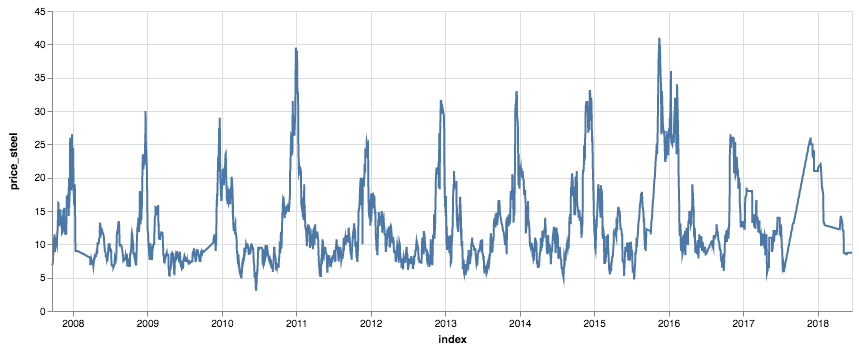

In [160]:
# Historical trends, as interpolated
alt.Chart(steel.reset_index()).mark_line().encode(
    x='index',
    y='price_steel'
).properties(width=800)

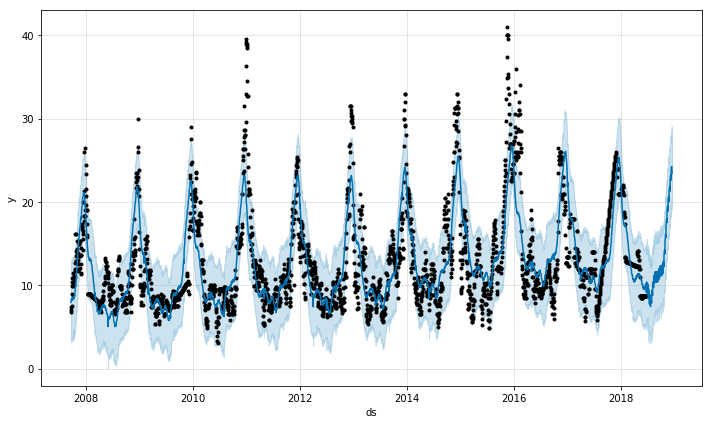

In [185]:
# Forecast trends
steel_model.plot(steel_forecast);

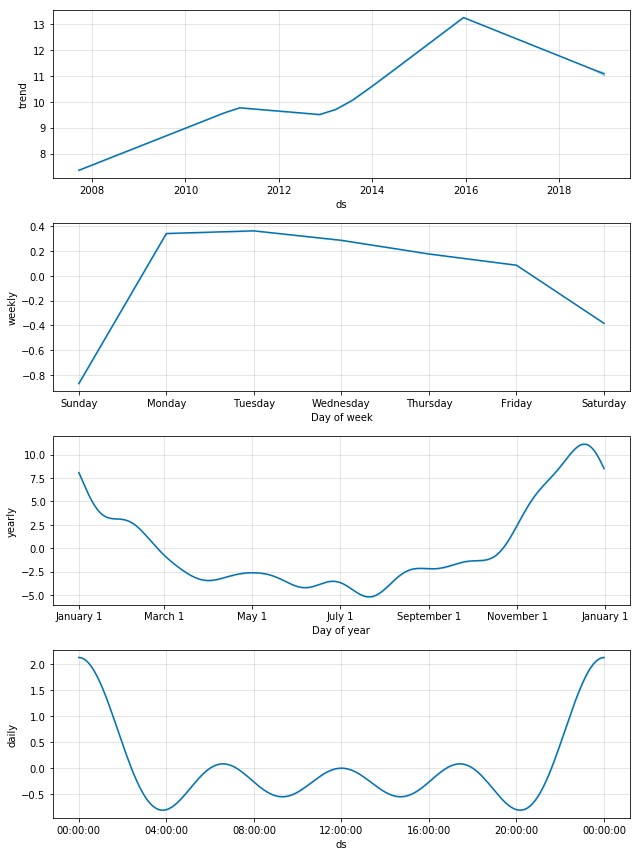

In [186]:
# Forecast trends
steel_model.plot_components(steel_forecast);

## Rebar

Rebar is trending significantly upward in price and, like steel, tends to spike in the winter months. However, rebar shows a unique trend compared to steel in that it typically reaches its lowest price for the year in the early summer but with substantial fluctuations that are difficult to predict around. Rebar should be purchased in bulk, as allows, during the early summer months of May and June. If it can't be avioded, purchasing for winter projects/demand should take place in October.  

The forecast for rebar suggests that bulk purchases should be made as soon as possible as once the price increases above $20 per unit, it's likely to rise much higher at a rapid pace. Rebar tends to be lowest in price on Sundays and highest on Saturdays.

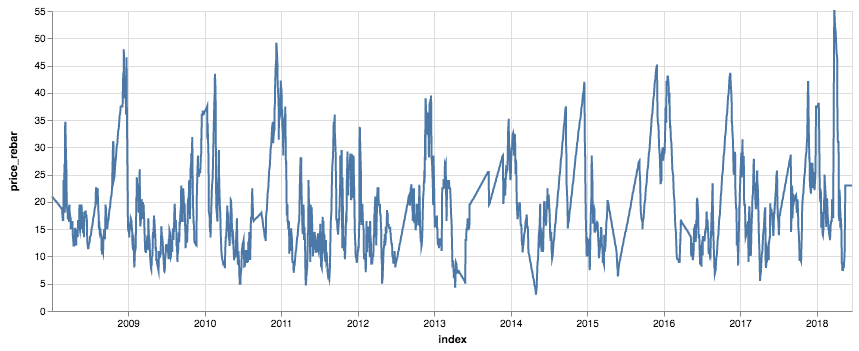

In [159]:
# Historical trends, as interpolated
alt.Chart(rebar.reset_index()).mark_line().encode(
    x='index',
    y='price_rebar'
).properties(width=800)

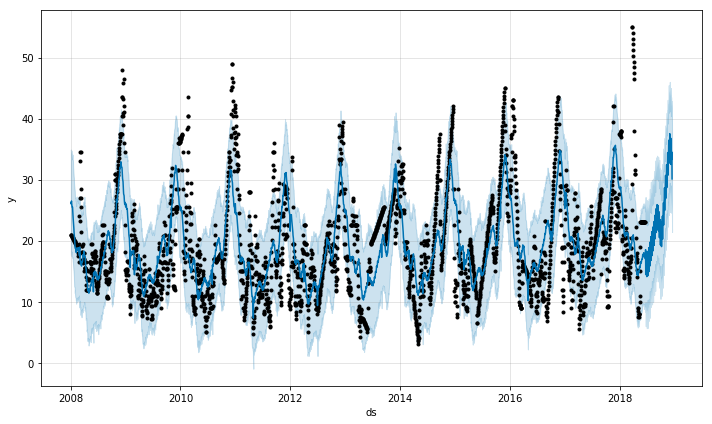

In [188]:
# Forecast trends
rebar_model.plot(rebar_forecast);

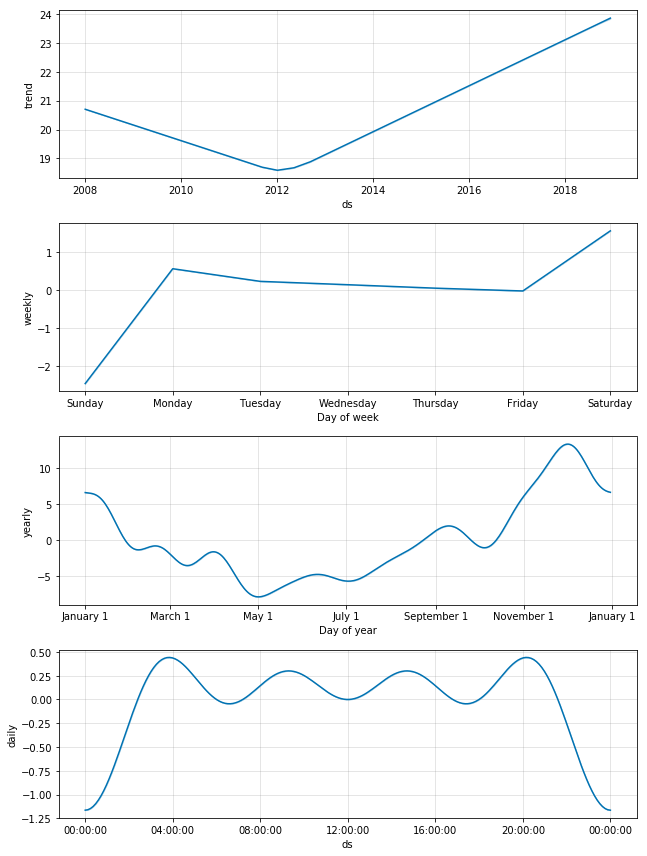

In [187]:
# Rebar forecast
rebar_model.plot_components(rebar_forecast) ;

## Glass

The data for glass is the most sparse, and as such the trends should be noted as being more difficult to predict. Glass is trending as being pricey, which should be reflected in cost models for the material in bids, etc. No significant downward or upward trend is able to be predicted for the next 6 months for glass, but it does tend to increase in price during the Spring months of March, April, and May. Prices at ~$35 per unit are possible soon but if the prices begin to rise, it is suggested to buy in bulk at the first sign. 

Glass should not be purchased on Saturdays if possible, as they tend to have much higher prices on Saturdays. 

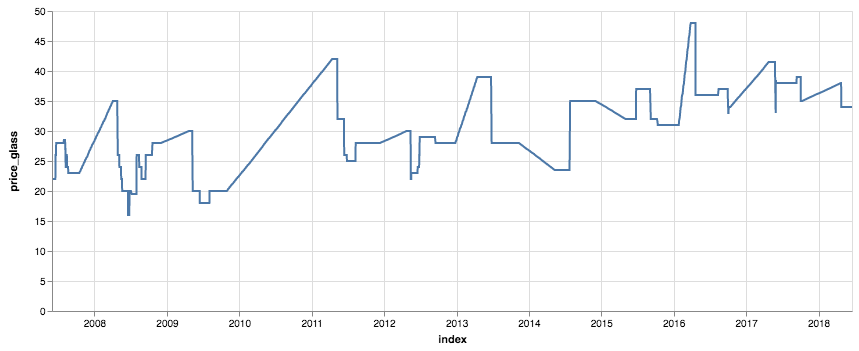

In [161]:
# Historical trends, as interpolated
alt.Chart(glass.reset_index()).mark_line().encode(
    x='index',
    y='price_glass'
).properties(width=800)

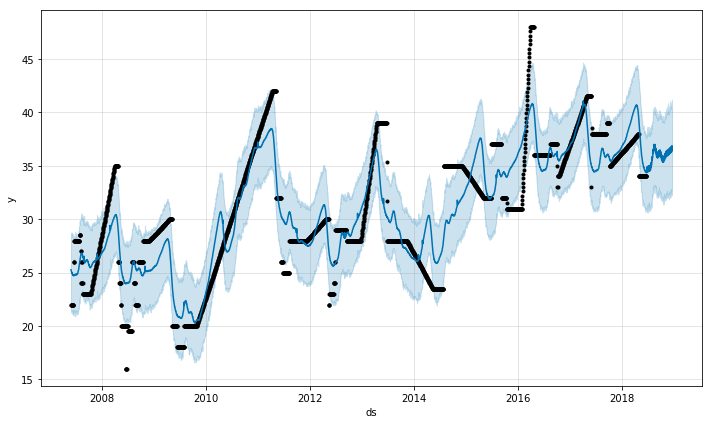

In [189]:
# Forecast trends
glass_model.plot(glass_forecast);

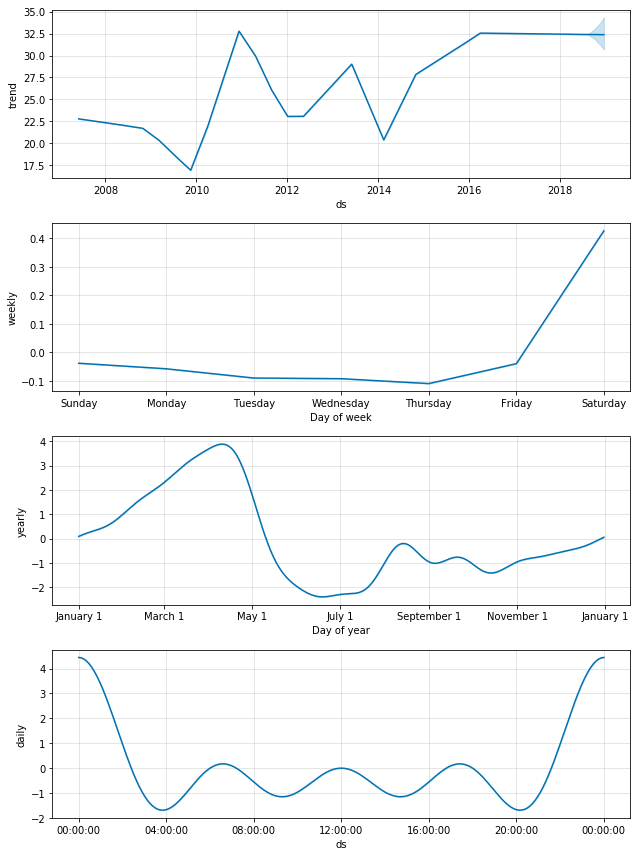

In [190]:
glass_model.plot_components(glass_forecast);

## Concrete

Concrete tends to increase in price in the late Spring and into the early Summer before declining significantly in the late summer. As a result, it should be purchased in July and August in bulk if possible and on Sundays if possible. The forecast suggests that a major dip in prices is in store and waiting a month or two would be recommended to see a drop in price from today's date. The price may drop as low as ~$35 per unit in the coming weeks or months before rising to above \\$30-40 per unit later this year. Concrete drops in price on Sundays, so be on the lookout for deals on Sundays. 

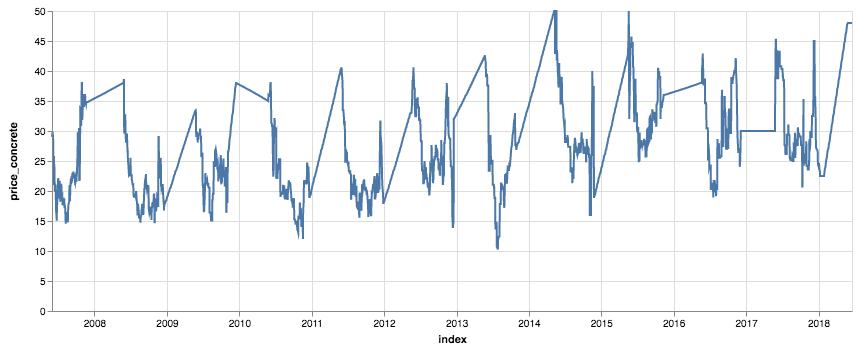

In [162]:
# Historical trends, as interpolated
alt.Chart(concrete.reset_index()).mark_line().encode(
    x='index',
    y='price_concrete'
).properties(width=800)

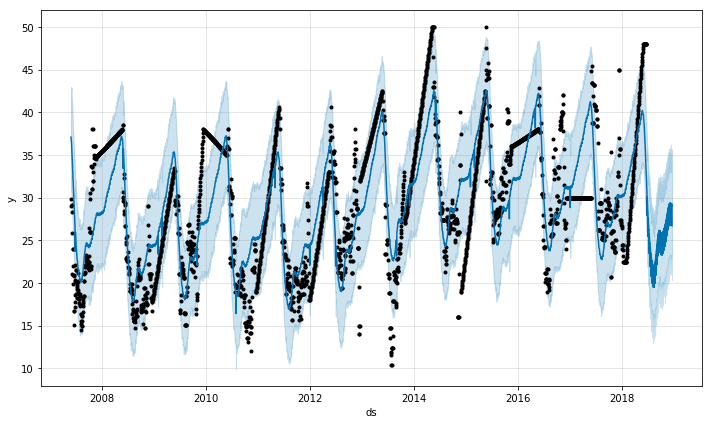

In [192]:
# Forecast trends
concrete_model.plot(concrete_forecast);

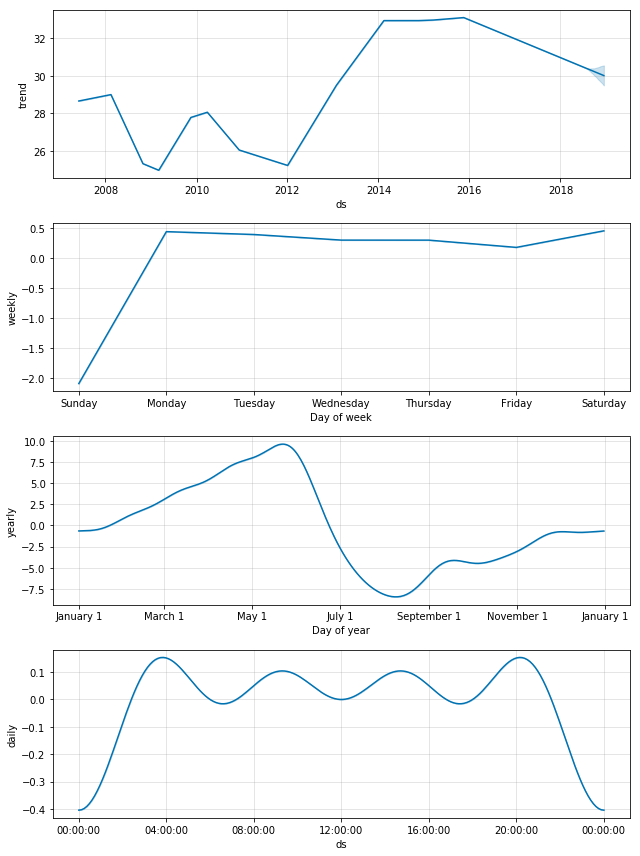

In [191]:
concrete_model.plot_components(concrete_forecast);

## Plywood

Plywood sees major fluctuations in price during a given year, but in particular spikes dramatically in price in the late winter, late summer, and most noticably in October. These spikes have likely cut into company profits. The pricing forecasts suggests an increase is likely in the next month or two, which will followed by a substantial drop in price before it rises again. Buy as soon as the price goes under $11-12, which should be in the next few months.

Buy plywood later in the week if possible. 

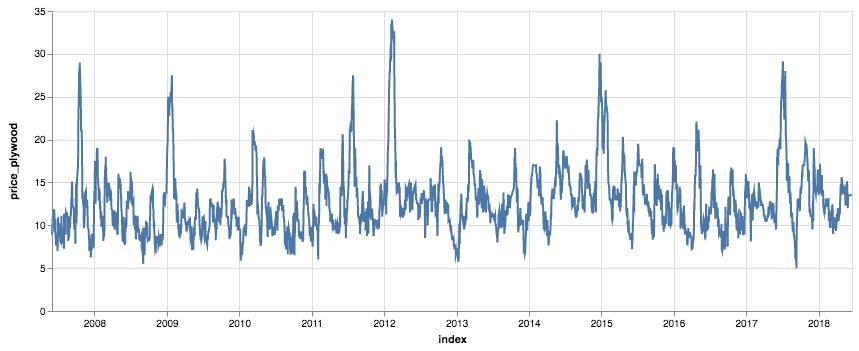

In [164]:
# Historical trends, as interpolated
alt.Chart(plywood.reset_index()).mark_line().encode(
    x='index',
    y='price_plywood'
).properties(width=800)

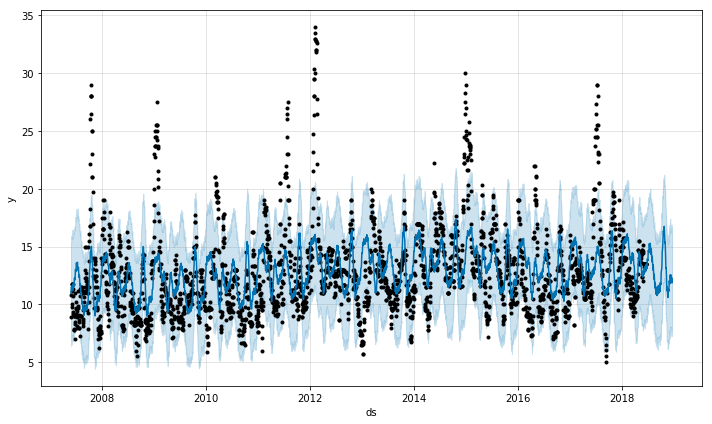

In [193]:
# Forecast trends
plywood_model.plot(plywood_forecast);

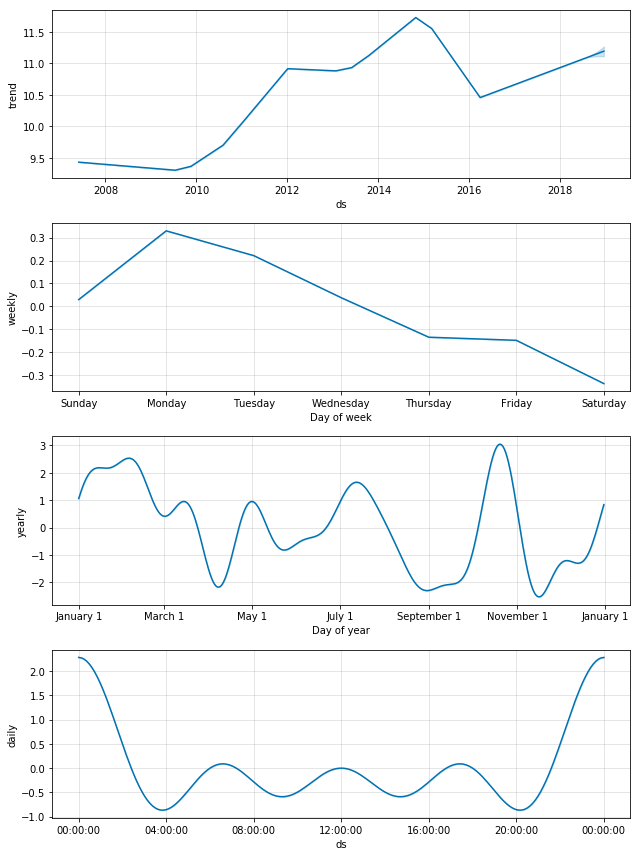

In [194]:
plywood_model.plot_components(plywood_forecast);